## Introduction


For our project we have decided to analyse the dataset titled "Predict Student's Dropout and Academic Success". The dataset is created from data collected by higher education institutes (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. 

Furthermore, the dataset includes information known at the time of the student's enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. 

The research question we would like to answer is a classification one where we create a model that allows us to predict whether a student will graduate or drop out of a higher education institute based on their high school grade average and the admission grade of the higher education institute they chose to attend. The admission grade of a university is the average grade required to be admitted to the school. The predictor variable "Target" is a categorical variable that contains 3 categories: dropout, enrolled and graduate. The categories relevant to our analysis are dropout and graduate.

The column titled previous qualification (grade) is a continous column with numbers [0, 200] that represents the student's grade at their previous qualification (whether it be highschool or during their bachelor's degree). The column titled admission grade is also a continuous column with numbers [0, 200] representing the grade set for entry to the institution.

dataset: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success?fbclid=IwAR3ffegYP7CAXRy-izSVKVpd0-vHXf-t4c61G4zQogzcFzUUXAR2hQD1uM0

## Initial Data Exploration

In [2]:
#Run this cell to attach libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')
library(RColorBrewer)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
data <- read_delim(file = "data/data.csv", delim = ";") #Load the data into R. File is semi-colon separated so use read_delim function
head(data)

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital_status, Application_mode, Application_order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Marital_status,Application_mode,Application_order,Course,Daytime/evening attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mother_qualification,Father_qualification,⋯,Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without evaluations),Unemployment_rate,Inflation_rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.66667,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.40000,0,9.4,-0.8,-3.12,Graduate
2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.00000,0,13.9,-0.3,0.79,Graduate
2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.50000,5,16.2,0.3,-0.92,Graduate


To tidy the data set, we have decided to implement the following steps:\
__Step 1:__ Select only the columns we want to use in our model (predictor variables + predictor class)\
__Step 2:__ Filter the previous qualifications column so we are only examining students being admitted who have only completed high school\
__Step 3:__ Filter the predictor class Target to have only two categories "Graduate and Dropout" as we only want to consider the two classes and predict whether a student will drop out or graduate\
__Step 4:__ Transform our "Target" column into a factor as it is our predictor class\
__Step 5:__ Check whether we have a sufficient amount of observations that meet our criteria

In [4]:
tidy_data <- data|>
select(Previous_qualification, Previous_qualification_grade, Admission_grade, Target) |> # select our columns of interest
filter(Previous_qualification == 1) |> #We only want to examine observations whose previous education is completed secondary education
filter(Target == "Graduate" | Target == "Dropout") |> #We only want to examine the binary of dropout vs graduate (not students currently enrolled)
mutate(Target = as_factor(Target)) #We want our classification variable to be a factor as there's a limited amount of categories
head(tidy_data)
nrow(tidy_data) #Check we still have a sufficient amount of observations that meet our criteria

Previous_qualification,Previous_qualification_grade,Admission_grade,Target
<dbl>,<dbl>,<dbl>,<fct>
1,122,127.3,Dropout
1,160,142.5,Graduate
1,122,124.8,Dropout
1,122,119.6,Graduate
1,100,141.5,Graduate
1,142,128.4,Graduate


[1] 3019

__Create a Training Data Set__

In [5]:
#Split the data into training and testing. 75% for training and 25% for testing.
# Because we are classifying target, use that as strata.
data_split <- initial_split(tidy_data, prop = 0.75, strata = Target) 
dropout_training <- training(data_split) #name training and testing data sets
dropout_testing <- testing(data_split)

__Graphing__

In [6]:
mean_admission_grade <- dropout_training |>
select(Target, Admission_grade) |>
group_by(Target) |>
summarize(grade = mean(Admission_grade))
mean_admission_grade
mean_qualification_grade <- dropout_training |>
select(Target, Previous_qualification_grade) |>
group_by(Target) |>
summarize(grade = mean(Previous_qualification_grade))
mean_qualification_grade

Target,grade
<fct>,<dbl>
Dropout,124.2454
Graduate,127.9546


Target,grade
<fct>,<dbl>
Dropout,130.9458
Graduate,134.2297


Target,count
<fct>,<int>
Dropout,808
Graduate,1455


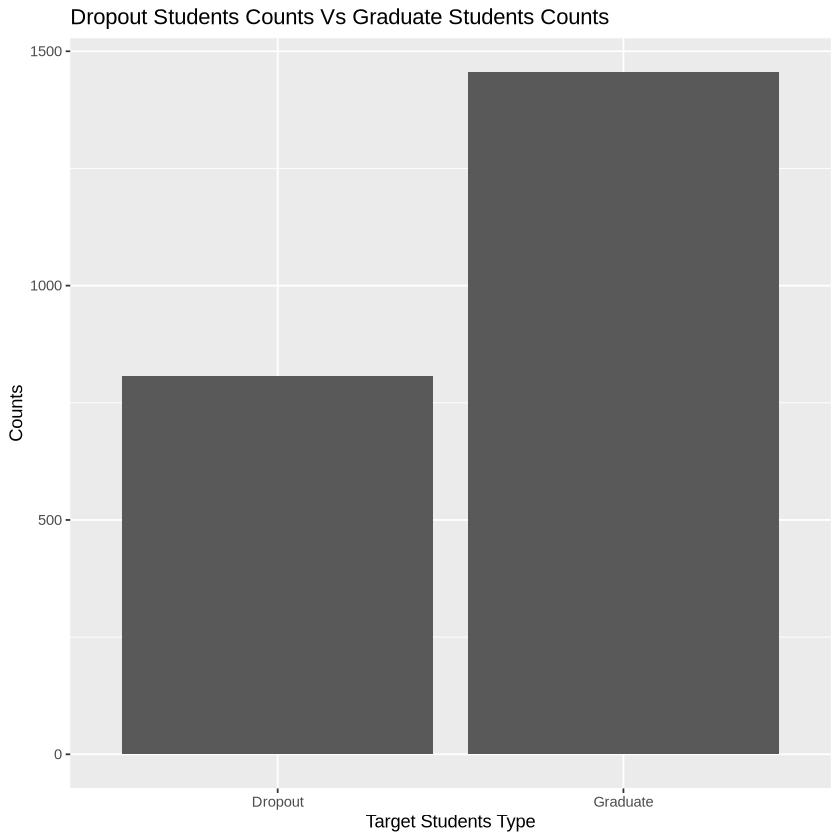

In [7]:
target_count_data <- dropout_training |>
group_by(Target) |>
summarise(count = n())
target_count_data
target_count_graph <- target_count_data |>
ggplot(aes(x = Target, y = count)) +
geom_bar(stat = "identity")+
labs(x = "Target Students Type", y = "Counts") +
ggtitle("Dropout Students Counts Vs Graduate Students Counts ")
target_count_graph 

The bar graph above, titled "Droppout Students Vs Graduate Students Counts" illustrates the split of the dataset between the number of students who dropped out and who graduated. Based on the graph, it is evident that 
there is a disproportionately high number of students who graduated from a higher secondary instituition. Therefore, when we are analysing our data, we may have 
to conduct oversampling to ensure that the numbers for students who graduated and students who dropped out are comparable. This will help ensure that the analysis 
is unbiased and the results are more reliable. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


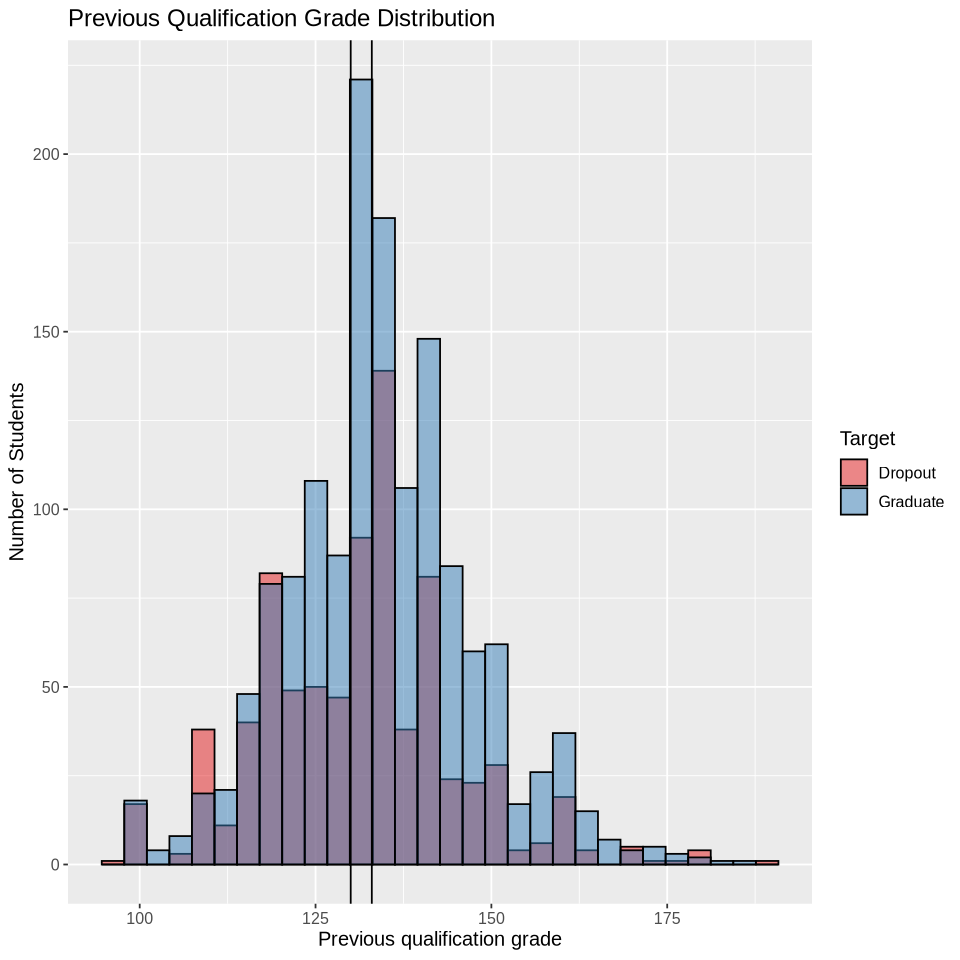

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
  ggplot(aes(x = Previous_qualification_grade, fill = Target)) +
  geom_histogram(color = 'black', alpha = 0.5, position = "identity") +
  geom_vline(xintercept = 130 ) +
  geom_vline(xintercept = 133 ) +
labs( x = "Previous qualification grade", y = "Number of Students", fill = "Target") +
  scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 12))+
ggtitle("Previous Qualification Grade Distribution")
grade_plot

The histogram titled "Previous Qualification Grade Distribution" showcases the distribution of the previous grade acheieved by the high school student before they entered the higher education instituition. Furthemore, this graph helps us visualise the distribution and gives us an overview of the performance of the students we are analysing. The data is split into two colours that overlap each other and represent the two catergories of students that are drop out and graduate. It helps us directly compare the distribution of the two.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


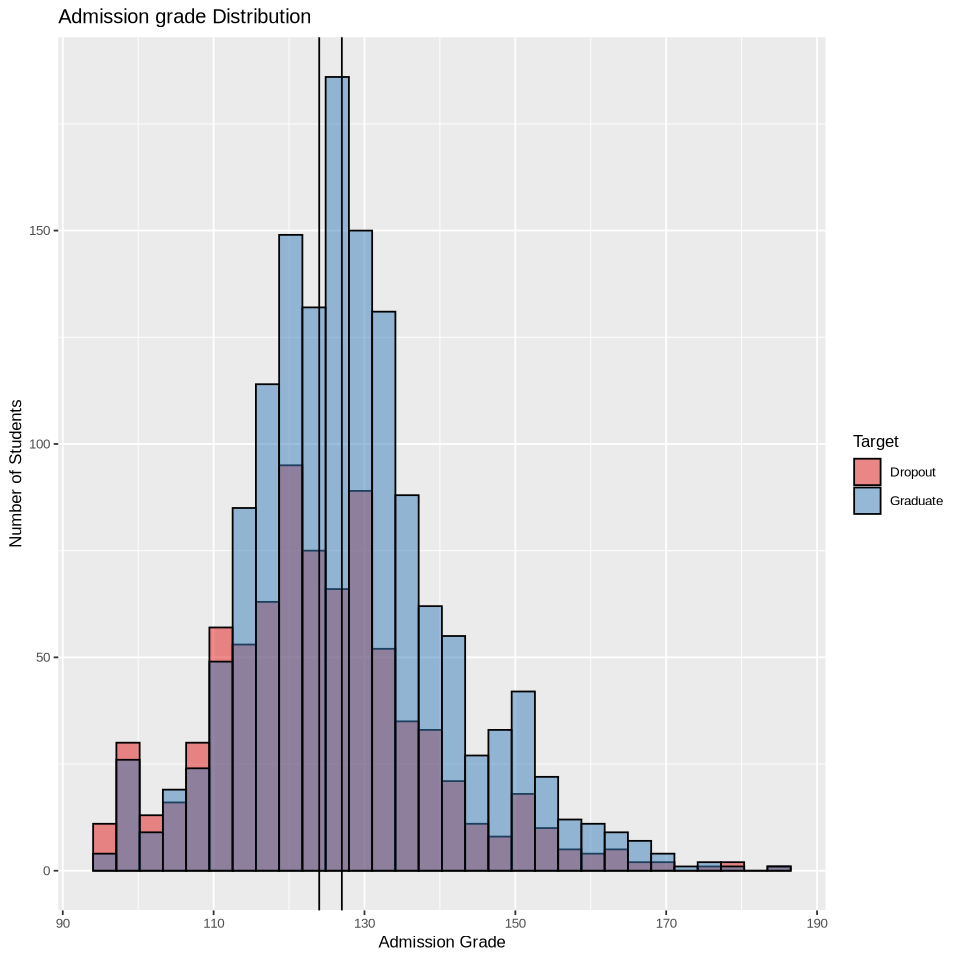

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
  ggplot(aes(x = Admission_grade, fill = Target)) +
  geom_histogram(color = 'Black', alpha = 0.5, position = "identity") +
  geom_vline(xintercept = 124) +
  geom_vline(xintercept = 127) +
  labs( x = "Admission Grade", y = "Number of Students", fill = "Target") + 
scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 10)) +
ggtitle("Admission grade Distribution")
grade_plot

The histogram titled "Admission Grade Distribtution" serves a similar purpose to that earlier graph, except it visualises the distribution of the average admission grade and the number of students who selected schools with that speicific admission grade. Once again, the students are split into dropout and graduated catergories by colours to differentiate and compare their admission grade distributions.

The two histograms aid in illustrating the distributions of the two predictor variables we plan to use for our classification analysis to answer the research question. It works as a guideline to ensure that our analysis isn't unbiased and that our results are reliable.

## Methods

We are going to use the K-nearest neighbors classification model to predict whether a student will graduate or drop out. Our predictors will be admission grade of the university they attend and the grade they received in high school. We think this is an interesting analysis as it could allow students to evaluate their chances of success when choosing which higher education institute to attend.

As mentioned earlier, when we split the data into the training and testing, there is disproportionately high number of students who graduated and therefore, before we do any analysis we may have to do oversampling to ensure the analysis is reliable.

Additionally, to conduct the analysis, we will choose the k-closest neighbors to the student (let's call them student p)whose Target variable we want to predict. To do this, we have to first scale the data and then calculate the distance of all the points of data from the dataset from the the point of student p. This is done by summing the square of the differences between the variables admission grades and the previous qualifications of the students in the dataset and student p and then finding the squareroot. After which, we arrange all the distances in ascending order and choose the first k neighbors. We then conduct cross-validation to pick paramter k to choose the "best" value that ensures that we do not face the problems of overfitting or underfitting.

## Expected outcomes and significance

We expect to be able to reliably predict the Target variable of a new student, which states whether they dropped out or graduated from a higher education instituition. By extension, this implies that the predictor variables are relevant to the determination of whether a student drops out or graduates. 

The impact of these findings is that policies could be catered to aid in improving the previous qualification (grade) of the students and matching the two predictor variables to ensure that the Target variable is that the student graduates. 

Lastly, this research could be extended to investigate the relationship between students and other socioeconomic factors. These could be economy-wide factors such as GDP and inflation rate or indivdial-student-based factors such as their parents qualifications.